# Introduction

Ce notebook permet de tester les algorithmes découverts dans la partie Bibliographique.

## Importing libraries

In [1]:
import numpy as np

from collections import OrderedDict
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Textrank

First example of an algorithm found on :
[TDS](https://towardsdatascience.com/textrank-for-keyword-extraction-by-python-c0bae21bcec0)
* Using a direct graph matrix, we get:

In [28]:
# Implementation of the direct similarity matrix table
g = [[0, 0, 0, 0],
     [0, 0, 0, 0],
     [1, 0.5, 0, 0],
     [0, 0.5, 0, 0]]

# Transformation into a matrix
g = np.array(g)

# Node vector initialization at 1
pr = np.array([1, 1, 1, 1]) 

# Initialization of d which is damping factor
# It allows you to have no zero values.
d = 0.85

# Iterations
for iter in range(10):
    # Formula uses a matrix product
    pr = (1-d) + d * np.dot(g, pr)
    print(iter)
    print(pr)

0
[0.15  0.15  1.425 0.575]
1
[0.15    0.15    0.34125 0.21375]
2
[0.15    0.15    0.34125 0.21375]
3
[0.15    0.15    0.34125 0.21375]
4
[0.15    0.15    0.34125 0.21375]
5
[0.15    0.15    0.34125 0.21375]
6
[0.15    0.15    0.34125 0.21375]
7
[0.15    0.15    0.34125 0.21375]
8
[0.15    0.15    0.34125 0.21375]
9
[0.15    0.15    0.34125 0.21375]


* Using a symmetrical, normalized matrix, i.e. corresponding to an undirected graph, we obtain

In [7]:
# Implementation of the Unsupervised Similarity Matrix Table
g = [[0, 0, 0.5, 0],
     [0, 0, 0.5, 1],
     [1, 0.5, 0, 0],
     [0, 0.5, 0, 0]]

# Transformation into a matrix
g = np.array(g)

# Node vector initialization at 1
pr = np.array([1, 1, 1, 1]) 

# Initialization of d which is damping factor
# It allows you to have no zero values.
d = 0.85

# Iterations
for iter in range(10):
    # Formula uses a matrix product
    pr = (1-d) + d * np.dot(g, pr)
    print(iter)
    print(pr)

0
[0.575 1.425 1.425 0.575]
1
[0.755625 1.244375 1.244375 0.755625]
2
[0.67885937 1.32114062 1.32114062 0.67885937]
3
[0.71148477 1.28851523 1.28851523 0.71148477]
4
[0.69761897 1.30238103 1.30238103 0.69761897]
5
[0.70351194 1.29648806 1.29648806 0.70351194]
6
[0.70100743 1.29899257 1.29899257 0.70100743]
7
[0.70207184 1.29792816 1.29792816 0.70207184]
8
[0.70161947 1.29838053 1.29838053 0.70161947]
9
[0.70181173 1.29818827 1.29818827 0.70181173]


__Analysis of this example:__
The value for the third column, for example, changes between the case where the graph is directed and the case where it is not directed. 

* Sample code for keyword extractions:

In [8]:
nlp = en_core_web_sm.load()

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

In [9]:
text = '''
The Wandering Earth, described as China’s first big-budget science fiction thriller, quietly made it onto screens at AMC theaters in North America this weekend, and it shows a new side of Chinese filmmaking — one focused toward futuristic spectacles rather than China’s traditionally grand, massive historical epics. At the same time, The Wandering Earth feels like a throwback to a few familiar eras of American filmmaking. While the film’s cast, setting, and tone are all Chinese, longtime science fiction fans are going to see a lot on the screen that reminds them of other movies, for better or worse.
'''

tr4w = TextRank4Keyword()
tr4w.analyze(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)
tr4w.get_keywords(10)

science - 1.7276378287292111
fiction - 1.7123791481736559
filmmaking - 1.4388798751402918
China - 1.4172218029410266
Earth - 1.3088154732297723
tone - 1.0971675275482093
fans - 1.0971675275482093
Wandering - 1.0071059904601571
weekend - 1.002449354657688
America - 0.9976329264870932
budget - 0.9769693829073562
North - 0.9711240881032547


* Mise en place d'une fonction

In [10]:
def Mots_du_texte(texte,taille_window,nombre_key_word):
    tr4w = TextRank4Keyword()
    tr4w.analyze(texte, candidate_pos = ['NOUN', 'PROPN'], window_size=taille_window, lower=False)
    return(tr4w.get_keywords(nombre_key_word))

In [11]:
texte_personnel="Je vais bien, le soleil brille dehors, les animaux dansent dans le laboratoire, je mange des glaces mais je fait du sport"
Mots_du_texte(texte_personnel,4,10)

le - 1.8383715277777775
je - 1.7962256944444444
soleil - 1.035357638888889
mais - 1.0167048611111111
brille - 1.0036597222222223
des - 0.9749722222222221
mange - 0.9621041666666666
dehors - 0.9592708333333332
animaux - 0.9592708333333332
dans - 0.9526597222222222
dansent - 0.9351874999999998
laboratoire - 0.9265694444444443


* Variation  de la fenetre

In [12]:
Mots_du_texte(texte_personnel,6,10)

le - 1.7845327601410936
je - 1.5454166666666667
des - 1.1004146825396826
brille - 1.0725588183421517
mange - 1.071609126984127
dehors - 1.0512863315696648
animaux - 1.0416709876543209
dans - 1.0332339506172838
dansent - 1.0287523368606701
mais - 1.0177443121693122
soleil - 0.9796652116402117
laboratoire - 0.9360880952380953


* Variation du nombre de mots à afficher

In [13]:
Mots_du_texte(texte_personnel,4,60)

le - 1.8383715277777775
je - 1.7962256944444444
soleil - 1.035357638888889
mais - 1.0167048611111111
brille - 1.0036597222222223
des - 0.9749722222222221
mange - 0.9621041666666666
dehors - 0.9592708333333332
animaux - 0.9592708333333332
dans - 0.9526597222222222
dansent - 0.9351874999999998
laboratoire - 0.9265694444444443
bien - 0.9187187499999999
fait - 0.8986493055555554
vais - 0.7797083333333333
du - 0.769673611111111
Je - 0.6364479166666667
sport - 0.6364479166666667


## Visualisation with graphs

In [14]:
???????

Object `` not found.


## Use of NLP

Application des commandes sur : https://www.stat4decision.com/fr/traitement-langage-naturel-francais-tal-nlp/

In [15]:
import spacy
#import fr_core_news_sm
import en_core_web_sm
#nlp = fr_core_news_sm.load()

### Tokenization of words

Cette partie est indépendante de la langue utilisée, elle fonctionne à la fois pour le francais et l'anglais.

In [16]:
def return_token(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque token
    return [X.text for X in doc]

In [17]:
test = "This is a test"
return_token(test)

['This', 'is', 'a', 'test']

### Remove frequent words

In [18]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
stopWords_en = set(stopwords.words('english'))
stopWords_fr = set(stopwords.words('french'))

In [19]:
clean_words = []
for token in return_token(test):
    if token not in stopWords_en:
        clean_words.append(token)
for token in return_token(test):
    if token not in stopWords_fr:
        clean_words.append(token)

clean_words

['This', 'test', 'This', 'is', 'a', 'test']

On peut vérifier si la liste des mots chargés pour le francais fonctionne également:

In [20]:
texte_francais= "Je pense que ce texte est intéressant pour un premier essai en francais."
clean_words = []
for token in return_token(texte_francais):
    if token not in stopWords_fr:
        clean_words.append(token)
clean_words

['Je', 'pense', 'texte', 'intéressant', 'premier', 'essai', 'francais', '.']

### Tokenization of sentences

Cette partie est indépendante de la langue utilisée, elle fonctionne à la fois pour le francais et l'anglais.

In [21]:
def return_token_sent(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque phrase
    return [X.text for X in doc.sents]

In [22]:
return_token_sent("Bouygues a eu une coupure de réseau à Marseille. La panne a affecté 300.000 utilisateurs.")

['Bouygues a eu une coupure de réseau',
 'à Marseille.',
 'La panne a affecté 300.000 utilisateurs.']

### Stemming

On peut essayer en francais:

In [23]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

def return_stem(sentence):
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

In [24]:
return_stem("Pouvons nous découper les mots avec les racines?")

['pouvon', 'nous', 'découp', 'le', 'mot', 'avec', 'le', 'racin', '?']

De même, en anglais cela donnerait:

In [25]:
stemmer = SnowballStemmer(language='english')

def return_stem(sentence):
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

In [26]:
return_stem("Will you cut my sentence?")

['will', 'you', 'cut', 'my', 'sentenc', '?']

### Find named entities

En anglais, il est possible de retrouver des personnes ou des lieux déjà existants:

In [27]:
def return_NER(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte et le label pour chaque entité
    return [(X.text, X.label_) for X in doc.ents]

In [28]:
return_NER("Michael Jackson went to London")

[('Michael Jackson', 'PERSON'), ('London', 'GPE')]

Il est possible de réaliser une visualisation graphique de ces entités:

In [29]:
from spacy import displacy
doc = nlp("Michael Jackson went to London with SNCF")
displacy.render(doc, style="ent", jupyter=True)

Modification des couleurs et sélection de ceux à afficher:

In [30]:
doc = nlp("Michael Jackson went to London with SNCF")
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ORG"], "colors": colors}

displacy.render(doc, style="ent", jupyter=True, options=options)

### We can also work on the syntactic style:

Par exemple reperer le type grammatiquale dans la phrase, mais il peut y avoir des problèmes:

In [31]:
def return_POS(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner les étiquettes de chaque token
    return [(X, X.pos_) for X in doc]

In [32]:
return_POS(test)

[(This, 'DET'), (is, 'AUX'), (a, 'DET'), (test, 'NOUN')]

On peut visualiser cela et les dépendances par le biais de graphe.

In [35]:
doc = nlp(test)
displacy.serve(doc, style="dep")

/usr/lib/python3.6/runpy.py:193: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  "__main__", mod_spec)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


### Passage in the form of vectors:

In [34]:
def return_word_embedding(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le vecteur lié à chaque token
    return [(X.vector) for X in doc]

In [35]:
return_word_embedding(test)

[array([-2.8289204 ,  1.6081493 , -2.5203147 , -3.0620356 , -0.5288159 ,
         0.17312291,  5.508917  , -0.25038946,  0.96570516,  0.68806773,
        -0.26124418, -0.61018115, -2.025521  ,  0.11490172, -1.025383  ,
        -1.6966306 , -0.04849267, -1.1192627 , -1.0795952 , -3.227298  ,
         0.51651967, -0.4366228 ,  0.27434194,  2.8039007 , -0.4724449 ,
         3.2797494 , -1.1268538 , -1.5990881 , -2.7512755 , -0.94182336,
         1.1187562 , -2.108296  ,  0.3462378 , -2.2731736 ,  4.894237  ,
         1.3413675 , -1.5411592 ,  1.2883343 , -4.3428526 ,  1.6281406 ,
        -4.0285864 ,  1.7769263 ,  0.9340485 ,  0.01327991, -0.08885574,
         1.8237207 , -0.49523   , -2.7214339 , -4.7531404 , -1.8392645 ,
        -1.16852   ,  0.13758813,  1.8126571 , -2.2450554 ,  1.5332721 ,
         3.3352475 , -3.2497358 ,  2.6440866 ,  4.0503073 , -3.4607995 ,
         0.93535125,  0.0356707 ,  2.5027862 ,  0.19765568, -2.515706  ,
        -1.4111778 ,  2.890166  , -4.4749827 ,  0.5

### Similarity between sentences:

In [36]:
def return_tensor(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner la moyenne des vecteurs pour chaque phrase
    return np.mean([(X.vector) for X in doc], axis=0)

In [37]:
test_2 = "I can play piano with my hands"
test_3 = "There is icecream  on the table"
test_4 = "The project is fabulous"

In [38]:
print(np.linalg.norm(return_tensor(test)-return_tensor(test_2)))
print(np.linalg.norm(return_tensor(test)-return_tensor(test_3)))
print(np.linalg.norm(return_tensor(test)-return_tensor(test_4)))

15.5451565
12.079011
11.422031


### Type management

In [39]:
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

Noun phrases: ['Michael Jackson', 'London', 'SNCF']
Verbs: ['go']


In [47]:
phrase_fr_1=("I try something different""Yes yes I mean, said Michael Jackson as he wants to the SNCF")
doc_fr_1=nlp(phrase_fr_1)
print("Noun phrases:", [chunk.text for chunk in doc_fr_1.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc_fr_1 if token.pos_ == "VERB"])

Noun phrases: ['I', 'something', 'I', 'Michael Jackson', 'he', 'the SNCF']
Verbs: ['try', 'differentyes', 'mean', 'say', 'want']


In [48]:
for entity in doc_fr_1.ents:
    print(entity.text, entity.label_)

Michael Jackson PERSON
SNCF ORG


### Brief use of nltk

In [53]:
import nltk
#nltk.download('punkt')
sentence = """At eight o'clock on Thursday morning"""
tokens = nltk.word_tokenize(sentence)
tokens

['At', 'eight', "o'clock", 'on', 'Thursday', 'morning']

In [58]:
#nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged

[('At', 'IN'),
 ('eight', 'CD'),
 ("o'clock", 'NN'),
 ('on', 'IN'),
 ('Thursday', 'NNP'),
 ('morning', 'NN')]

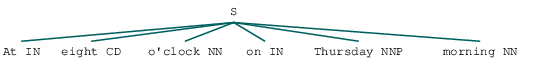

In [63]:
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities

In [69]:
from nltk.corpus import treebank
#nltk.download('treebank')
t = treebank.parsed_sents('wsj_0001.mrg')[0]
t.draw()

## Converting PDF to txt

In [3]:
import pdftotext
 
# Load your PDF
with open("/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/TP-TdJ.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)
 
# Save all text to a txt file.
with open("/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/TP-TdJ.txt", 'w') as f:
    f.write("\n\n".join(pdf))

In [4]:
import json 

In [7]:
filename = "/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/melanie.txt"

# dictionary where the lines from 
dict1 = {} 
  
# creating dictionary 
with open(filename) as fh: 
  
    for line in fh: 
  
        # reads each line and trims of extra the spaces  
        # and gives only the valid words 
        command, description = line.strip().split(None, 1) 
  
        dict1[command] = description.strip() 
  
# the JSON file is named as test1 
out_file = open("/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/melanie.json","w") 
json.dump(dict1, out_file, indent = 4, sort_keys = False) 
out_file.close() 

In [1]:
import pdftotext
 
# Load your PDF
with open("/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/covid.pdf", "rb") as f:
    pdf = pdftotext.PDF(f)
 
# Save all text to a txt file.
with open("/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/covid.txt", 'w') as f:
    f.write("\n\n".join(pdf))

In [1]:
my_file = open("/home/manie/Documents/Stage/stage_analyse_de_texte/ConversionPDF_txt/covid.txt", 'r') 
txt = my_file.read()
text=""
for i in range(0,len(txt)-1):
    if not (txt[i]==" " and txt[i+1]==" "):
        text=text+txt[i]
#print(txt)
#print(text)

List_sections_all = ['abstract','introduction','results','discussion','back_matter','data collection','acknowledgments','statistical analysis','methods','background','declaration of interests','interpretation','conclusion','body']
for i in List_sections_all:
    if i in text:
        print(i,"ok")
        print(text.count(i))
    else:
        print(i,'not in list')

abstract not in list
introduction not in list
results ok
2
discussion not in list
back_matter not in list
data collection not in list
acknowledgments not in list
statistical analysis not in list
methods not in list
background not in list
declaration of interests not in list
interpretation not in list
conclusion not in list
body ok
1


### regular expressions

In [75]:
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

txt=" This is a test with H1N1 and 290 people +!)"
txt_token = word_tokenize(txt)

# avec lower, il y a conversion en minuscule
s = [re.sub(r'[^a-zA-Z]+', '', w).lower() for w in txt_token]
s

['this', 'is', 'a', 'test', 'with', 'hn', 'and', '', 'people', '', '', '']

Si on enleve les majuscules, alors le mot est toujours présent mais pas la lettre

In [76]:
s = [re.sub(r'[^a-z]+', '', w).lower() for w in txt_token]
s

['his', 'is', 'a', 'test', 'with', '', 'and', '', 'people', '', '', '']

In [77]:
english_stop_words = stopwords.words('english')
s = [re.sub(r'[^a-zA-Z0-9]+', '', w).lower() for w in txt_token]
print("Avant d'enlevé les mots : ",s)
s = [w for w in s if w not in english_stop_words]
print("Apres avoir enlevé les mots :",s)

Avant d'enlevé les mots :  ['this', 'is', 'a', 'test', 'with', 'h1n1', 'and', '290', 'people', '', '', '']
Apres avoir enlevé les mots : ['test', 'h1n1', '290', 'people', '', '', '']


In [103]:
english_stop_words = stopwords.words('english')
s = [re.sub(r'[^a-zA-Z0-9]+', '', w).lower() for w in txt_token]
print("Avant d'enlevé les mots : ",s)
s= [w for w in s if w is not ""]
print("Apres avoir enlevé les vides :",s)
s = [w for w in s if w not in english_stop_words]
print("Apres avoir enlevé les mots récurrents :",s)
l=[]
for i in range(len(s)):
    w=s[i]
    if re.search(r"[a-z]", w) is not None:
        l.append(w)
print("Apres avoir enlevé les nombres :",l)

Avant d'enlevé les mots :  ['this', 'is', 'a', 'test', 'with', 'h1n1', 'and', '290', 'people', '', '', '']
Apres avoir enlevé les vides : ['this', 'is', 'a', 'test', 'with', 'h1n1', 'and', '290', 'people']
Apres avoir enlevé les mots récurrents : ['test', 'h1n1', '290', 'people']
Apres avoir enlevé les nombres : ['test', 'h1n1', 'people']


In [104]:
chaine = "06899898989"
expression = r"^0[0-9]([ .-]?[0-9]{2}){4}$"
while re.search(expression, chaine) is None:
    chaine = input("Saisissez un numéro de téléphone (valide): ")
print("Le dernier numéro est valide: "+chaine)

Saisissez un numéro de téléphone (valide): 0989898989
Le dernier numéro est valide: 0989898989


## Alternative to regular expressions

In [107]:
txt=" This is a test with H1N1 and 290 people +!)"
x = txt.isalnum()
print(x) 
print("La phrase contient des caractères non alphanumériques.")

False
La phrase contient des caractères non alphanumériques


In [119]:
txt_token = word_tokenize(txt)
# Mise en minuscule
s = [w.lower() for w in txt_token]
print("Passage en minuscule",s)
s =[ w for w in s if w.isalnum()]
print("Enleve les non alphanumériques",s)
s =[ w for w in s if not w.isnumeric()]
print("Enleve les nombres",s)

Passage en minuscule ['this', 'is', 'a', 'test', 'with', 'h1n1', 'and', '290', 'people', '+', '!', ')']
Enleve les non alphanumériques ['this', 'is', 'a', 'test', 'with', 'h1n1', 'and', '290', 'people']
Enleve les nombres ['this', 'is', 'a', 'test', 'with', 'h1n1', 'and', 'people']


## Apriori

In [8]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori


dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)

frequent_itemsets

support                     itemsets
0       0.8                       (Eggs)
1       1.0               (Kidney Beans)
2       0.6                       (Milk)
3       0.6                      (Onion)
4       0.6                     (Yogurt)
5       0.8         (Kidney Beans, Eggs)
6       0.6                (Eggs, Onion)
7       0.6         (Milk, Kidney Beans)
8       0.6        (Kidney Beans, Onion)
9       0.6       (Yogurt, Kidney Beans)
10      0.6  (Kidney Beans, Eggs, Onion)

In [9]:
from mlxtend.frequent_patterns import association_rules

association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)


antecedents            consequents  antecedent support  \
0          (Kidney Beans)                 (Eggs)                 1.0   
1                  (Eggs)         (Kidney Beans)                 0.8   
2                  (Eggs)                (Onion)                 0.8   
3                 (Onion)                 (Eggs)                 0.6   
4                  (Milk)         (Kidney Beans)                 0.6   
5                 (Onion)         (Kidney Beans)                 0.6   
6                (Yogurt)         (Kidney Beans)                 0.6   
7    (Kidney Beans, Eggs)                (Onion)                 0.8   
8   (Kidney Beans, Onion)                 (Eggs)                 0.6   
9           (Eggs, Onion)         (Kidney Beans)                 0.6   
10                 (Eggs)  (Kidney Beans, Onion)                 0.8   
11                (Onion)   (Kidney Beans, Eggs)                 0.6   

    consequent support  support  confidence  lift  leverage  conviction  
0                  0.8      0.8        0.80  1.00      0.00         1.0  
1                  1.0      0.8        1.00  1.00      0.00         inf  
2                  0.6      0.6        0.75  1.25      0.12         1.6  
3                  0.8      0.6        1.00  1.25      0.12         inf  
4                  1.0      0.6        1.00  1.00      0.00         inf  
5                  1.0      0.6        1.00  1.00      0.00         inf  
6                  1.0      0.6        1.00  1.00      0.00         inf  
7                  0.6      0.6        0.75  1.25      0.12         1.6  
8                  0.8      0.6        1.00  1.25      0.12         inf  
9                  1.0      0.6        1.00  1.00      0.00         inf  
10                 0.6      0.6        0.75  1.25      0.12         1.6  
11                 0.8      0.6        1.00  1.25      0.12         inf

In [10]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules

antecedents            consequents  antecedent support  \
0                 (Eggs)                (Onion)                 0.8   
1                (Onion)                 (Eggs)                 0.6   
2   (Kidney Beans, Eggs)                (Onion)                 0.8   
3  (Kidney Beans, Onion)                 (Eggs)                 0.6   
4                 (Eggs)  (Kidney Beans, Onion)                 0.8   
5                (Onion)   (Kidney Beans, Eggs)                 0.6   

   consequent support  support  confidence  lift  leverage  conviction  
0                 0.6      0.6        0.75  1.25      0.12         1.6  
1                 0.8      0.6        1.00  1.25      0.12         inf  
2                 0.6      0.6        0.75  1.25      0.12         1.6  
3                 0.8      0.6        1.00  1.25      0.12         inf  
4                 0.6      0.6        0.75  1.25      0.12         1.6  
5                 0.8      0.6        1.00  1.25      0.12         inf

In [11]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

antecedents            consequents  antecedent support  \
0                 (Eggs)                (Onion)                 0.8   
1                (Onion)                 (Eggs)                 0.6   
2   (Kidney Beans, Eggs)                (Onion)                 0.8   
3  (Kidney Beans, Onion)                 (Eggs)                 0.6   
4                 (Eggs)  (Kidney Beans, Onion)                 0.8   
5                (Onion)   (Kidney Beans, Eggs)                 0.6   

   consequent support  support  confidence  lift  leverage  conviction  \
0                 0.6      0.6        0.75  1.25      0.12         1.6   
1                 0.8      0.6        1.00  1.25      0.12         inf   
2                 0.6      0.6        0.75  1.25      0.12         1.6   
3                 0.8      0.6        1.00  1.25      0.12         inf   
4                 0.6      0.6        0.75  1.25      0.12         1.6   
5                 0.8      0.6        1.00  1.25      0.12         inf   

   antecedent_len  
0               1  
1               1  
2               2  
3               2  
4               1  
5               1

In [14]:
support=rules.as_matrix(columns=['support'])
confidence=rules.as_matrix(columns=['confidence'])

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [12]:
import random
import matplotlib.pyplot as plt
 
 
for i in range (len(support)):
   support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
   confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

NameError: name 'support' is not defined

In [1]:
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
            
            
import pandas as pd
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori
 
oht = OnehotTransactions()
oht_ary = oht.fit(dataset).transform(dataset)
df = pd.DataFrame(oht_ary, columns=oht.columns_)
print (df)           
 
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
print (frequent_itemsets)
 
from mlxtend.frequent_patterns import association_rules
 
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
print (rules)
 
support=rules.as_matrix(columns=['support'])
confidence=rules.as_matrix(columns=['confidence'])
 
 
import random
import matplotlib.pyplot as plt
 
 
for i in range (len(support)):
   support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
   confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()
 
import numpy as np
 
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedants']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from()
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()
 
     
draw_graph (rules, 6)   
 
 
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
 
 
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]
 
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
 
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
 
basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
 
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
 
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()
 
print (rules)
 
 
 
support=rules.as_matrix(columns=['support'])
confidence=rules.as_matrix(columns=['confidence'])
 
import seaborn as sns1
 
for i in range (len(support)):
    support[i] = support[i] 
    confidence[i] = confidence[i] 
     
plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')    
sns1.regplot(x=support, y=confidence, fit_reg=False)
 
plt.gcf().clear()
draw_graph (rules, 10)  

ImportError: cannot import name 'OnehotTransactions' from 'mlxtend.preprocessing' (/home/manie/Documents/ENTER/lib/python3.7/site-packages/mlxtend/preprocessing/__init__.py)